Nama : Ilham Fikriansyah

Email : ilhamfikriansyah112145@upi.edu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
#https://www.kaggle.com/mattiuzc/stock-exchange-data
df = pd.read_csv('/content/sample_data/indexData.csv')
df

,Index,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0
...,...,...,...,...,...,...,...,...
112452,N100,2021-05-27,1241.119995,1251.910034,1241.119995,1247.069946,1247.069946,379696400.0
112453,N100,2021-05-28,1249.469971,1259.209961,1249.030029,1256.599976,1256.599976,160773400.0
112454,N100,2021-05-31,1256.079956,1258.880005,1248.140015,1248.930054,1248.930054,91173700.0
112455,N100,2021-06-01,1254.609985,1265.660034,1254.609985,1258.579956,1258.579956,155179900.0


In [3]:
df['Index'].unique()

array(['NYA', 'IXIC', 'HSI', '000001.SS', 'GSPTSE', '399001.SZ', 'NSEI',
       'GDAXI', 'KS11', 'SSMI', 'TWII', 'J203.JO', 'N225', 'N100'],
      dtype=object)

In [4]:
df = df[['Index','Date','High']]
df

,Index,Date,High
0,NYA,1965-12-31,528.690002
1,NYA,1966-01-03,527.210022
2,NYA,1966-01-04,527.840027
3,NYA,1966-01-05,531.119995
4,NYA,1966-01-06,532.070007
...,...,...,...
112452,N100,2021-05-27,1251.910034
112453,N100,2021-05-28,1259.209961
112454,N100,2021-05-31,1258.880005
112455,N100,2021-06-01,1265.660034


In [5]:
df_baru = df.loc[(df['Index'] == 'NYA')].reset_index()
del df_baru['index']
del df_baru['Index']
df_baru

,Date,High
0,1965-12-31,528.690002
1,1966-01-03,527.210022
2,1966-01-04,527.840027
3,1966-01-05,531.119995
4,1966-01-06,532.070007
...,...,...
13943,2021-05-24,16508.519530
13944,2021-05-25,16525.810550
13945,2021-05-26,16466.339840
13946,2021-05-27,16546.359380


In [6]:
df_baru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13948 entries, 0 to 13947
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    13948 non-null  object 
 1   High    13947 non-null  float64
dtypes: float64(1), object(1)
memory usage: 218.1+ KB


In [7]:
import datetime as dt
df_baru['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df_baru = df_baru.dropna(axis = 0, how ='any')
df_baru.set_index('Date', inplace= True)
df_baru

,High
Date,
1965-12-31,528.690002
1966-01-03,527.210022
1966-01-04,527.840027
1966-01-05,531.119995
1966-01-06,532.070007
...,...
2021-05-24,16508.519530
2021-05-25,16525.810550
2021-05-26,16466.339840


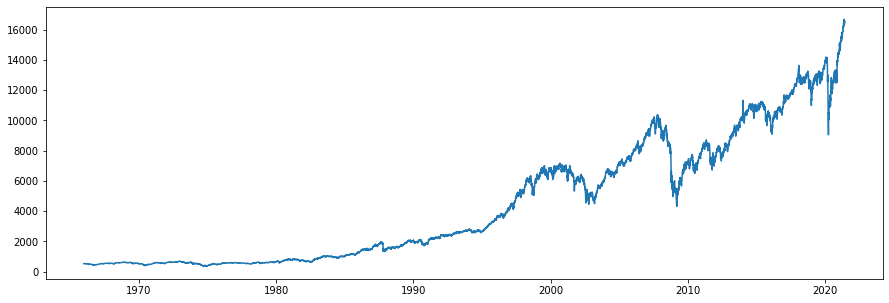

In [8]:
plt.figure(figsize=(15,5))
plt.plot(df_baru.index,df_baru.High)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_baru.values, test_size=0.2, shuffle=False)

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scale = scaler.fit_transform(train.reshape(-1, 1))
test_scale = scaler.fit_transform(test.reshape(-1, 1))

In [11]:
from keras.preprocessing.sequence import TimeseriesGenerator
look_back = 32

train_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(train_scale, train_scale, length=look_back, batch_size=10)
test_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(test_scale, test_scale, length=look_back, batch_size=10)

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.1):
      print("\nMean Absolute Error telah mencapai < 10%!")
      self.model.stop_training = True
callbacks = myCallback()

In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, activation='relu', return_sequences=True),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(1)
])

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_gen, validation_data = test_gen, epochs=50, verbose=2, callbacks = [callbacks])

Epoch 1/50
1113/1113 - 16s - loss: 0.0583 - mae: 0.2387 - val_loss: 0.0388 - val_mae: 0.2289
Epoch 2/50
1113/1113 - 14s - loss: 0.0307 - mae: 0.2077 - val_loss: 0.0248 - val_mae: 0.1829
Epoch 3/50
1113/1113 - 14s - loss: 0.0244 - mae: 0.1881 - val_loss: 0.0189 - val_mae: 0.1598
Epoch 4/50
1113/1113 - 14s - loss: 0.0195 - mae: 0.1683 - val_loss: 0.0151 - val_mae: 0.1428
Epoch 5/50
1113/1113 - 14s - loss: 0.0156 - mae: 0.1481 - val_loss: 0.0114 - val_mae: 0.1244
Epoch 6/50
1113/1113 - 14s - loss: 0.0127 - mae: 0.1309 - val_loss: 0.0085 - val_mae: 0.1079
Epoch 7/50
1113/1113 - 14s - loss: 0.0100 - mae: 0.1129 - val_loss: 0.0062 - val_mae: 0.0928
Epoch 8/50
1113/1113 - 14s - loss: 0.0082 - mae: 0.0980 - val_loss: 0.0048 - val_mae: 0.0819

Mean Absolute Error telah mencapai < 10%!


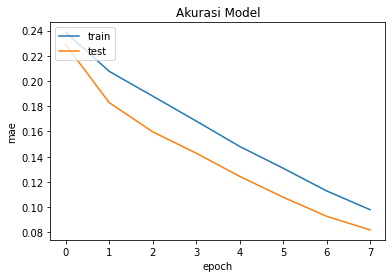

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

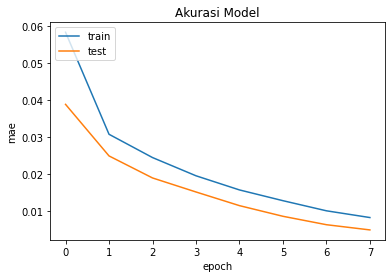

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Akurasi Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()